In [ ]:
!python -m pip install https://github.com/p-koo/tfomics/tarball/master
!pip install logomaker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 19 kB 1.6 MB/s
     |████████████████████████████████| 11.8 MB 5.0 MB/s 
  Created wheel for tfomics: filename=tfomics-0.1.0.dev0-py3-none-any.whl size=23206 sha256=d8034922205276dac43297030fab9b5878f3c7e97d4cfab65759de0e3e55318b
  Stored in directory: /tmp/pip-ephem-wheel-cache-flpf_j5b/wheels/e1/eb/ae/f064df77529927df479c5f666c7572e25493375bcd4c1ff19f
Successfully built tfomics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob, h5py, os, re, sys, time
from pathlib import Path
from six.moves import cPickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tfomics
import logomaker

In [ ]:
def calculate_angles(saliency_score):
    orthogonal_residual = np.sum(saliency_score, axis=-1)
    L2_norm = np.sqrt(np.sum(np.square(saliency_score), axis=-1))
    sine = 1/2 * orthogonal_residual / L2_norm 
    sine = np.arcsin(sine) * (180/3.1416) 
    return sine

def matrix_to_df(x, w, alphabet='ACGT'):
    """generate pandas dataframe for saliency plot
     based on grad x inputs """

    L, A = w.shape
    counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
    for a in range(A):
        for l in range(L):
            counts_df.iloc[l,a] = w[l,a]
    return counts_df

def plot_attribution_map(saliency_df, ax=None, figsize=(20,1), fontsize=16):
    """plot an attribution map using logomaker"""

    logomaker.Logo(saliency_df, figsize=figsize, ax=ax)
    if ax is None:
        ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", labelsize=fontsize)
    ax.tick_params(axis="y", labelsize=fontsize)
    plt.xticks([])


def plot_angle_logo(angles, ax=None, figsize=(20,1), fontsize=16):
    L = len(angles)
    counts_df = pd.DataFrame(data=0.0, columns=list('∧'), index=list(range(L)))
    for l in range(L):
        counts_df.iloc[l,0] = angles[l]

    logomaker.Logo(counts_df, figsize=figsize, ax=ax)  
    if ax is None:
        ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    ax.set_ylabel('Angle', fontsize=fontsize)
    ax.tick_params(axis="x", labelsize=fontsize)
    ax.tick_params(axis="y", labelsize=fontsize)

In [ ]:
cell_line_dir = "./data/atac/cell_line_testsets/cell_line_13.h5"
saliency_dir = "./data/atac/saliency_repo"

# CNN-Base (Exp)

Text(0.5, 0, 'Positions')

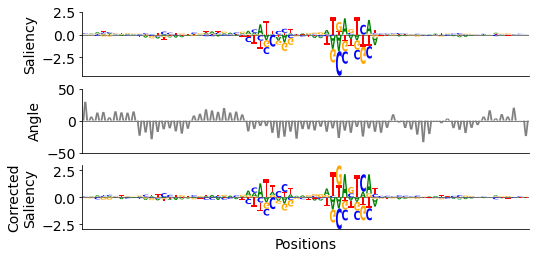

In [ ]:
attr_map_path = f"{saliency_dir}/new_models_CNN_1_all_Exp_PC-3.pickle"

# load attribution map
with open(attr_map_path, "rb") as input_file:
    saliency_scores = cPickle.load(input_file)[:]

# load test set
hf = h5py.File(cell_line_dir, 'r')
x_test = hf["X"][:]
y = hf["y"][:]
hf.close()

seq_idx = 3948

total_idx = []
for i in range(len(saliency_scores)):
    pos_idx = np.where(np.sum((saliency_scores[i] > 0), axis=1) == 4)[0]
    neg_idx = np.where(np.sum((saliency_scores[i] < 0), axis=1) == 4)[0]
    total_idx += [len(pos_idx) + len(neg_idx)]

total_idx = np.array(total_idx)

gs_indices = np.argsort(total_idx)[::-1]

gs_x_test = x_test[gs_indices]
gs_saliency_scores = saliency_scores[gs_indices]

# calculate angles
angles = calculate_angles(gs_saliency_scores) 
angles_flat = np.reshape(angles, [-1,])

index = np.where(gs_indices == seq_idx)[0][0]

window = 50
X = np.expand_dims(gs_x_test[index], axis=0)
sal_scores = np.expand_dims(gs_saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

start = 844
end = 918

plot_range = range(start, end)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-2.5,0,2.5])

ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
plt.yticks([-50,0,50])

ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Corrected\nSaliency', fontsize=14)

plt.yticks([-2.5,0,2.5])
ax.set_xlabel('Positions', fontsize=14)

Text(0.5, 0, 'Positions')

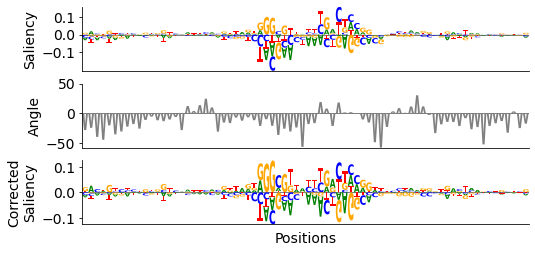

In [ ]:
attr_map_path = f"{saliency_dir}/new_models_CNN_1_all_Exp_PC-3.pickle"

# load attribution map
with open(attr_map_path, "rb") as input_file:
    saliency_scores = cPickle.load(input_file)[:]

# load test set
hf = h5py.File(cell_line_dir, 'r')
x_test = hf["X"][:]
y = hf["y"][:]
hf.close()

seq_idx = 3751

total_idx = []
for i in range(len(saliency_scores)):
    pos_idx = np.where(np.sum((saliency_scores[i] > 0), axis=1) == 4)[0]
    neg_idx = np.where(np.sum((saliency_scores[i] < 0), axis=1) == 4)[0]
    total_idx += [len(pos_idx) + len(neg_idx)]

total_idx = np.array(total_idx)

gs_indices = np.argsort(total_idx)[::-1]

gs_x_test = x_test[gs_indices]
gs_saliency_scores = saliency_scores[gs_indices]

# calculate angles
angles = calculate_angles(gs_saliency_scores) 
angles_flat = np.reshape(angles, [-1,])

index = np.where(gs_indices == seq_idx)[0][0]

window = 50
X = np.expand_dims(gs_x_test[index], axis=0)
sal_scores = np.expand_dims(gs_saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

start = 1628
end = 1702

plot_range = range(start, end)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-.1,0,.1])

ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
plt.yticks([-50,0,50])

ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Corrected\nSaliency', fontsize=14)

plt.yticks([-.1,0,.1])
ax.set_xlabel('Positions', fontsize=14)

# CNN-Base (ReLU)

Text(0.5, 0, 'Positions')

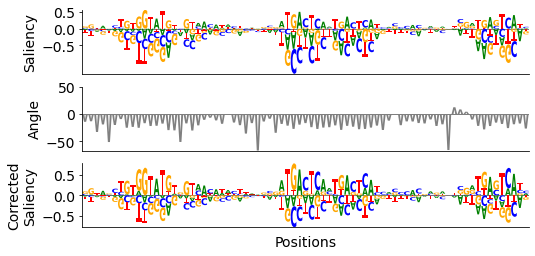

In [ ]:
attr_map_path = f"{saliency_dir}/new_models_CNN_1_all_ReLU_PC-3.pickle"

# load attribution map
with open(attr_map_path, "rb") as input_file:
    saliency_scores = cPickle.load(input_file)[:]

# load test set
hf = h5py.File(cell_line_dir, 'r')
x_test = hf["X"][:]
y = hf["y"][:]
hf.close()

seq_idx = 1796

total_idx = []
for i in range(len(saliency_scores)):
    pos_idx = np.where(np.sum((saliency_scores[i] > 0), axis=1) == 4)[0]
    neg_idx = np.where(np.sum((saliency_scores[i] < 0), axis=1) == 4)[0]
    total_idx += [len(pos_idx) + len(neg_idx)]

total_idx = np.array(total_idx)

gs_indices = np.argsort(total_idx)[::-1]

gs_x_test = x_test[gs_indices]
gs_saliency_scores = saliency_scores[gs_indices]

# calculate angles
angles = calculate_angles(gs_saliency_scores) 
angles_flat = np.reshape(angles, [-1,])

index = np.where(gs_indices == seq_idx)[0][0]

window = 50
X = np.expand_dims(gs_x_test[index], axis=0)
sal_scores = np.expand_dims(gs_saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

start = 1006
end = 1081

plot_range = range(start, end)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-.5,0,.5])

ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
plt.yticks([-50,0,50])

ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Corrected\nSaliency', fontsize=14)

plt.yticks([-.5,0,.5])
ax.set_xlabel('Positions', fontsize=14)

Text(0.5, 0, 'Positions')

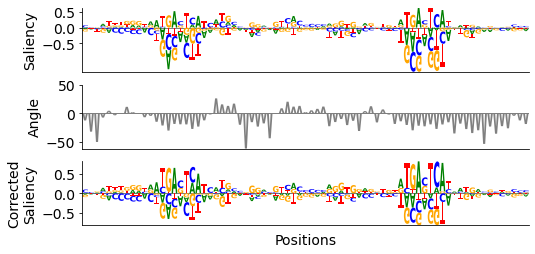

In [ ]:
attr_map_path = f"{saliency_dir}/new_models_CNN_1_all_ReLU_PC-3.pickle"

# load attribution map
with open(attr_map_path, "rb") as input_file:
    saliency_scores = cPickle.load(input_file)[:]

# load test set
hf = h5py.File(cell_line_dir, 'r')
x_test = hf["X"][:]
y = hf["y"][:]
hf.close()

seq_idx = 3222

total_idx = []
for i in range(len(saliency_scores)):
    pos_idx = np.where(np.sum((saliency_scores[i] > 0), axis=1) == 4)[0]
    neg_idx = np.where(np.sum((saliency_scores[i] < 0), axis=1) == 4)[0]
    total_idx += [len(pos_idx) + len(neg_idx)]

total_idx = np.array(total_idx)

gs_indices = np.argsort(total_idx)[::-1]

gs_x_test = x_test[gs_indices]
gs_saliency_scores = saliency_scores[gs_indices]

# calculate angles
angles = calculate_angles(gs_saliency_scores) 
angles_flat = np.reshape(angles, [-1,])

index = np.where(gs_indices == seq_idx)[0][0]

window = 50
X = np.expand_dims(gs_x_test[index], axis=0)
sal_scores = np.expand_dims(gs_saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

start = 649
end = 724

plot_range = range(start, end)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-.5,0,.5])

ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
plt.yticks([-50,0,50])

ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Corrected\nSaliency', fontsize=14)

plt.yticks([-.5,0,.5])
ax.set_xlabel('Positions', fontsize=14)

# CNN-32 (Exp)

Text(0.5, 0, 'Positions')

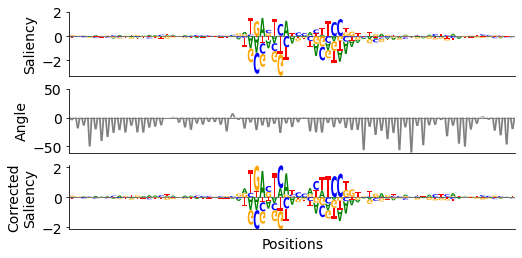

In [ ]:
attr_map_path = f"{saliency_dir}/new_models_CNN_32_all_Exp_PC-3.pickle"

# load attribution map
with open(attr_map_path, "rb") as input_file:
    saliency_scores = cPickle.load(input_file)[:]

# load test set
hf = h5py.File(cell_line_dir, 'r')
x_test = hf["X"][:]
y = hf["y"][:]
hf.close()

seq_idx = 3712

total_idx = []
for i in range(len(saliency_scores)):
    pos_idx = np.where(np.sum((saliency_scores[i] > 0), axis=1) == 4)[0]
    neg_idx = np.where(np.sum((saliency_scores[i] < 0), axis=1) == 4)[0]
    total_idx += [len(pos_idx) + len(neg_idx)]

total_idx = np.array(total_idx)

gs_indices = np.argsort(total_idx)[::-1]

gs_x_test = x_test[gs_indices]
gs_saliency_scores = saliency_scores[gs_indices]

# calculate angles
angles = calculate_angles(gs_saliency_scores) 
angles_flat = np.reshape(angles, [-1,])

index = np.where(gs_indices == seq_idx)[0][0]

window = 50
X = np.expand_dims(gs_x_test[index], axis=0)
sal_scores = np.expand_dims(gs_saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

start = 893 
end = 968

plot_range = range(start, end)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-2.,0,2.])

ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
plt.yticks([-50,0,50])

ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Corrected\nSaliency', fontsize=14)

plt.yticks([-2.,0,2.])
ax.set_xlabel('Positions', fontsize=14)

Text(0.5, 0, 'Positions')

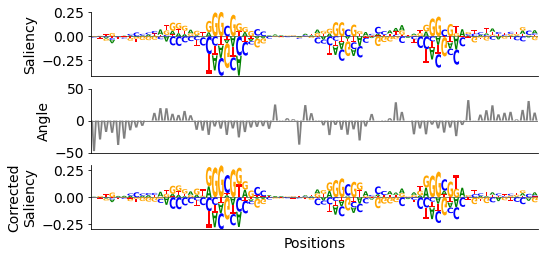

In [ ]:
attr_map_path = f"{saliency_dir}/new_models_CNN_32_all_Exp_PC-3.pickle"

# load attribution map
with open(attr_map_path, "rb") as input_file:
    saliency_scores = cPickle.load(input_file)[:]

# load test set
hf = h5py.File(cell_line_dir, 'r')
x_test = hf["X"][:]
y = hf["y"][:]
hf.close()

seq_idx = 1961

total_idx = []
for i in range(len(saliency_scores)):
    pos_idx = np.where(np.sum((saliency_scores[i] > 0), axis=1) == 4)[0]
    neg_idx = np.where(np.sum((saliency_scores[i] < 0), axis=1) == 4)[0]
    total_idx += [len(pos_idx) + len(neg_idx)]

total_idx = np.array(total_idx)

gs_indices = np.argsort(total_idx)[::-1]

gs_x_test = x_test[gs_indices]
gs_saliency_scores = saliency_scores[gs_indices]

# calculate angles
angles = calculate_angles(gs_saliency_scores) 
angles_flat = np.reshape(angles, [-1,])

index = np.where(gs_indices == seq_idx)[0][0]

window = 50
X = np.expand_dims(gs_x_test[index], axis=0)
sal_scores = np.expand_dims(gs_saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

start = 1440  
end = 1514

plot_range = range(start, end)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-.25,0,.25])

ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
plt.yticks([-50,0,50])

ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Corrected\nSaliency', fontsize=14)

plt.yticks([-.25,0,.25])
ax.set_xlabel('Positions', fontsize=14)

# CNN-32 (ReLU)

Text(0.5, 0, 'Positions')

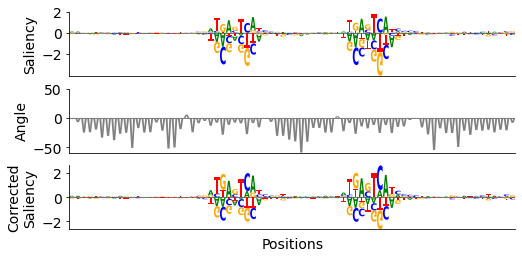

In [ ]:
attr_map_path = f"{saliency_dir}/new_models_CNN_32_all_Exp_PC-3.pickle"

# load attribution map
with open(attr_map_path, "rb") as input_file:
    saliency_scores = cPickle.load(input_file)[:]

# load test set
hf = h5py.File(cell_line_dir, 'r')
x_test = hf["X"][:]
y = hf["y"][:]
hf.close()

seq_idx = 2212

total_idx = []
for i in range(len(saliency_scores)):
    pos_idx = np.where(np.sum((saliency_scores[i] > 0), axis=1) == 4)[0]
    neg_idx = np.where(np.sum((saliency_scores[i] < 0), axis=1) == 4)[0]
    total_idx += [len(pos_idx) + len(neg_idx)]

total_idx = np.array(total_idx)

gs_indices = np.argsort(total_idx)[::-1]

gs_x_test = x_test[gs_indices]
gs_saliency_scores = saliency_scores[gs_indices]

# calculate angles
angles = calculate_angles(gs_saliency_scores) 
angles_flat = np.reshape(angles, [-1,])

index = np.where(gs_indices == seq_idx)[0][0]

window = 50
X = np.expand_dims(gs_x_test[index], axis=0)
sal_scores = np.expand_dims(gs_saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

start = 960  
end = 1034

plot_range = range(start, end)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-2.,0,2.])

ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
plt.yticks([-50,0,50])

ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Corrected\nSaliency', fontsize=14)

plt.yticks([-2.,0,2.])
ax.set_xlabel('Positions', fontsize=14)

Text(0.5, 0, 'Positions')

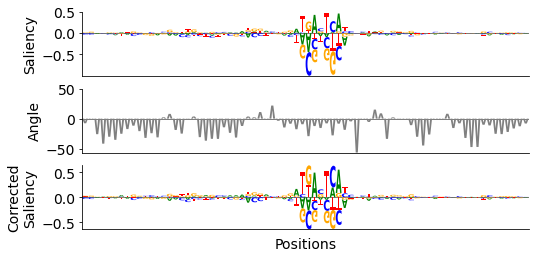

In [ ]:
attr_map_path = f"{saliency_dir}/new_models_CNN_32_all_Exp_PC-3.pickle"

# load attribution map
with open(attr_map_path, "rb") as input_file:
    saliency_scores = cPickle.load(input_file)[:]

# load test set
hf = h5py.File(cell_line_dir, 'r')
x_test = hf["X"][:]
y = hf["y"][:]
hf.close()

seq_idx = 791

total_idx = []
for i in range(len(saliency_scores)):
    pos_idx = np.where(np.sum((saliency_scores[i] > 0), axis=1) == 4)[0]
    neg_idx = np.where(np.sum((saliency_scores[i] < 0), axis=1) == 4)[0]
    total_idx += [len(pos_idx) + len(neg_idx)]

total_idx = np.array(total_idx)

gs_indices = np.argsort(total_idx)[::-1]

gs_x_test = x_test[gs_indices]
gs_saliency_scores = saliency_scores[gs_indices]

# calculate angles
angles = calculate_angles(gs_saliency_scores) 
angles_flat = np.reshape(angles, [-1,])

index = np.where(gs_indices == seq_idx)[0][0]

window = 50
X = np.expand_dims(gs_x_test[index], axis=0)
sal_scores = np.expand_dims(gs_saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

start = 961   
end = 1035

plot_range = range(start, end)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])


fig = plt.figure(figsize=(8,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-.5,0,.5])

ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
plt.yticks([-50,0,50])

ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Corrected\nSaliency', fontsize=14)

plt.yticks([-.5,0,.5])
ax.set_xlabel('Positions', fontsize=14)

# Plot Angle Histogram

In [ ]:
models = [
    "new_models_CNN_1_all_Exp", 
    "new_models_CNN_1_all_ReLU", 
    "new_models_CNN_32_all_Exp",
    "new_models_CNN_32_all_ReLU"
]

In [ ]:
angle_data = {}

for model in models:
    
    attr_map_path = f"{saliency_dir}/{model}_PC-3.pickle"

    # load attribution map
    with open(attr_map_path, "rb") as input_file:
        saliency_scores = cPickle.load(input_file)[:]

    # load test set
    hf = h5py.File(cell_line_dir, 'r')
    x_test = hf["X"][:]
    y = hf["y"][:]
    hf.close()



    total_idx = []
    for i in range(len(saliency_scores)):
        pos_idx = np.where(np.sum((saliency_scores[i] > 0), axis=1) == 4)[0]
        neg_idx = np.where(np.sum((saliency_scores[i] < 0), axis=1) == 4)[0]
        total_idx += [len(pos_idx) + len(neg_idx)]

    total_idx = np.array(total_idx)

    gs_indices = np.argsort(total_idx)[::-1]

    gs_x_test = x_test[gs_indices]
    gs_saliency_scores = saliency_scores[gs_indices]

    # calculate angles
    angles = calculate_angles(gs_saliency_scores) 
    angles_flat = np.reshape(angles, [-1,])
    
    angle_data[model] = angles_flat
    

In [ ]:
angle_df = pd.DataFrame(angle_data)
angle_df

,new_models_CNN_1_all_Exp,new_models_CNN_1_all_ReLU,new_models_CNN_32_all_Exp,new_models_CNN_32_all_ReLU
0,-9.443261,-14.634335,36.121399,18.882061
1,-55.487598,-2.983634,29.533430,3.040694
2,-10.937082,3.834976,10.851958,-1.072910
3,8.562882,-13.490609,21.512703,-7.721919
4,11.597282,-3.386523,14.299854,9.703677
...,...,...,...,...
8126459,32.398026,-18.272886,-14.436395,-5.615658
8126460,2.517844,-3.269177,-14.435597,-26.754320
8126461,1.074138,-5.975433,-0.878420,-10.888551
8126462,10.420753,-0.224490,4.764683,7.399245


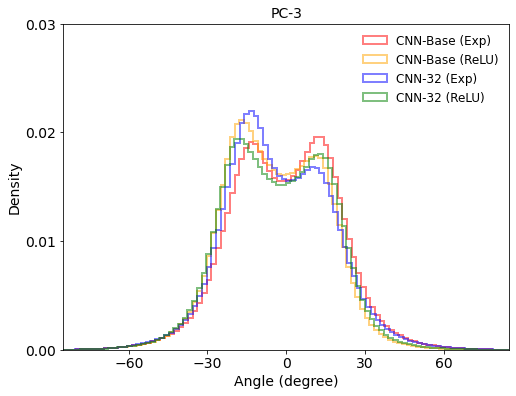

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.hist(angle_df["new_models_CNN_1_all_Exp"].to_numpy(), 100, density=True, alpha=0.5, color='r', histtype='step', linewidth=2)
plt.hist(angle_df["new_models_CNN_1_all_ReLU"].to_numpy(), 100, density=True, alpha=0.5, color='orange', histtype='step', linewidth=2)
plt.hist(angle_df["new_models_CNN_32_all_Exp"].to_numpy(), 100, density=True, alpha=0.5, color='b', histtype='step', linewidth=2)
plt.hist(angle_df["new_models_CNN_32_all_ReLU"].to_numpy(), 100, density=True, alpha=0.5, color='g', histtype='step', linewidth=2)
plt.ylabel('Density', fontsize=14)
plt.xlabel('Angle (degree)', fontsize=14)
plt.title('PC-3', fontsize=14)
plt.xticks([-60, -30, 0, 30, 60], fontsize=14)
plt.yticks(ticks=[0.0, 0.01, 0.02, 0.03], fontsize=14)
plt.xlim([-85, 85])
plt.legend(["CNN-Base (Exp)", "CNN-Base (ReLU)", "CNN-32 (Exp)", "CNN-32 (ReLU)"], fontsize=12, frameon=False)
plt.show()